C:\Users\User\Documents\repos\QD_LDS_readout\data\Tohoku data
(600000,) (600000,)


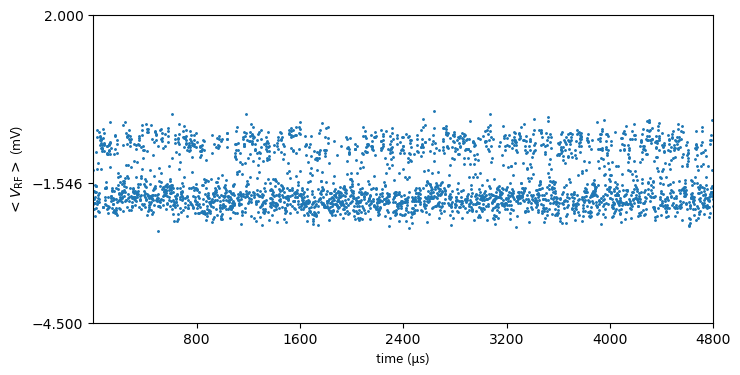

In [1]:
import expdata as ex
import numpy as np
import matplotlib.pyplot as plt
import os

#directory

path = r'C:\Users\User\Documents\repos\QD_LDS_readout\data\Tohoku data'
%cd $path

time_resolution = 8*1000#ns
def boxcar(t, signal, width = int(time_resolution/8)):
    print (t.shape, signal.shape)
    signal_ave = signal.reshape(-1, width).mean(axis = 1)
    t_ave = t.reshape(-1, width).mean(axis = 1)
    return t_ave, signal_ave
import h5py


d  = ex.load_data(201125150755)#200409155046, 201125150755
i = 1
n=200

"""
time, vrf = boxcar(d['time'].values, d['Vrf'].values[i],n)


#Draw graph with cutted plot
S_1, S_m = 36, 3600
s = S_1 * S_m / (S_1 * len(time) + S_m) # see
size = 4
fig = plt.figure(figsize= (size+1,size))
fig.patch.set_facecolor('white'); fig.patch.set_alpha(1.0)#; plt.tight_layout()
plt.scatter(time,vrf*1e3, s=s)
plt.xlim(0,8)
plt.ylim(-0.006*1e3,0.003*1e3)
#plt.yticks([-0.05*1e3, 0.015*1e3, -0.0005*1e3],fontsize=10)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8],fontsize=10)
plt.xlabel("time (μs)",fontname="Segoe UI",fontsize=10)
plt.ylabel("$<V_{\mathrm{RF}}>$ (mV)",fontname="Segoe UI",fontsize=10)
plt.show()

"""

#overall version
cumulative_time = np.array([d['time'].values])

for i in range(1,600):
    cumulative_time = np.concatenate((cumulative_time, np.array(i*d['time'].values[-1] + d['time'].values)), axis=None)
    #cumulative_time = np.array(cummulative_time)
    #cumulative_time.flatten()
    
time, vrf = boxcar(cumulative_time, d['Vrf'].values.flatten(),n)


S_1, S_m = 36, 3600
s = S_1 * S_m / (S_1 * len(time) + S_m) # see
size = 4
fig = plt.figure(figsize= (size+4,size))
fig.patch.set_facecolor('white'); fig.patch.set_alpha(1.0)#; plt.tight_layout()
plt.scatter(time,vrf*1e3, s=s)
plt.xlim(0,4800)
plt.ylim(-0.004*1e3,0.002*1e3)
plt.yticks([-0.0045*1e3, -0.0015464162726819232*1e3, 0.002*1e3],fontsize=10)
plt.xticks([800, 1600, 2400, 3200, 4000, 4800],fontsize=10)
plt.xlabel("time (μs)",fontname="Segoe UI",fontsize=10)
plt.ylabel("$<V_{\mathrm{RF}}>$ (mV)",fontname="Segoe UI",fontsize=10)
plt.show()

In [2]:
import lmfit
import xarray as xr

def new_array(orig_xarr, replaced_dim=None, new_dim=None, new_coords=None, name=None, dtype=None, fill_zeros=False):
    """Create a new empty xarray.DataArray with the same data structure as orig_xarr.
    If replaced_dim is given, the specified dimension is replaced with the new
    dimension name new_dim and the corresponding coordinates array new_coords."""
    shape = list(orig_xarr.shape)
    if replaced_dim is not None:
        if not isinstance(replaced_dim, int):
            # Extract dimension index to be replaced
            for i, dim_name in enumerate(orig_xarr.dims):
                if dim_name == replaced_dim:
                    replaced_dim = i
                    break
        if new_dim is None:
            del shape[replaced_dim]  # Just remove this dimension
        else:
            shape[replaced_dim] = len(new_coords)
    if dtype is None:
        dtype = orig_xarr.dtype
    num_array = np.zeros(shape, dtype=dtype) if fill_zeros else np.empty(shape, dtype=dtype)

    if isinstance(orig_xarr, xr.DataArray):
        # Copy coordinate information
        coords = []
        for i, dim_name in enumerate(orig_xarr.dims):
            if replaced_dim is not None and dim_name == orig_xarr.dims[replaced_dim]:
                if new_dim is not None:
                    coords.append((new_dim, new_coords))
            else:
                coords.append((dim_name, orig_xarr.coords[dim_name]))
        return xr.DataArray(num_array, coords, name=name, attrs=orig_xarr.attrs)
    else:
        return num_array


def find_thresholds(xarr, bins=None, xdrift=None, ydrift=None):
    """
    Find threshold values from binary scattered data or histrogram in xarr.
    Systematic drift of the threshold value is guessed automatically.

    :param array-like xarr: scattered value data or histogram data in xr.DataArray or other array-like types
    :param int,string bins: (required for histogram data) axis index or dimension name for bin values in histogram data
    :param int,string xdrift: (optional) axis index or dimension name along which the threshold drift should be guessed
    :param int,string ydrift: (optional) 2nd axis index or dimension name along which the threshold drift should be guessed
    :rtype: xr.DataArray
    :return: array of threshold values with the dimensions of ydrift and xdrift axes
    """
    def residual(pars, x=None, y=None, bins=None, data=None):
        # unpack parameters:
        #  extract .value attribute for each parameter
        parvals = pars.valuesdict()
        
        model = parvals['a0']
        if x is not None:
            model += parvals['a1'] * x + parvals['a2'] * x * x
        if y is not None:
            model += parvals['b1'] * y + parvals['b2'] * y * y
        if data is None:
            # Evaluate model values with the given parameters
            try:
                # Successful only when model is an instance of xarray
                model.name = 'thresholds'
            except:
                pass
            return model
        
        if bins is None:
            distances = np.abs(data - model)
        else:  # histogram data
            distances = np.abs(bins - model) * data
        m = np.mean(distances)
        return np.ravel(distances - m)

    xarr = xr.DataArray(xarr)
    kws = {'data':xarr}
    params = lmfit.Parameters()
    if bins is None:
        params.add('a0', np.median(xarr))
    else:
        bins = bins if bins in xarr.coords else xarr.dims[bins]
        kws['bins'] = xarr.coords[bins]
        params.add('a0', np.mean(xarr.coords[bins] * xarr))
    if xdrift is not None:
        params.add('a1', 0.)
        params.add('a2', 0.)
        xdrift = xdrift if xdrift in xarr.coords else xarr.dims[xdrift]
        kws['x'] = xarr.coords[xdrift]
    if ydrift is not None:
        params.add('b1', 0.)
        params.add('b2', 0.)
        ydrift = ydrift if ydrift in xarr.coords else xarr.dims[ydrift]
        kws['y'] = xarr.coords[ydrift]

    result = lmfit.minimize(residual, params, kws=kws)
    kws.pop('data')
    return residual(result.params, **kws)

In [3]:
threshold = find_thresholds(d['Vrf'].values.flatten())

In [4]:
print(threshold)

-0.0015464162726819232


In [18]:
import pandas as pd

def labeling(data, threshold, n):
    # Check if data length is divisible by n
    if len(data) % n != 0:
        raise ValueError("Length of data must be divisible by n")

    # Reshape data into 2D array of subarrays
    reshaped_data = data.reshape(-1, n)

    # Calculate mean of each subarray and compare with threshold
    # Assign labels accordingly
    labels = (reshaped_data.mean(axis=1) > threshold).astype(int)

    # Create a dataset (Pandas DataFrame)
    dataset = pd.DataFrame(reshaped_data, columns=[f'feature_{i}' for i in range(n)])
    dataset['label'] = labels

    # Export dataset to CSV
    dataset.to_csv('output_dataset.csv', index=False)

    return dataset

In [85]:
dataset = labeling(d['Vrf'].values.flatten(), threshold, 100)

In [92]:
with np.printoptions(threshold=np.inf):
    print(np.sum(dataset.label))

2267


In [5]:
def separate_data(data, threshold, n):
    # Check if data length is divisible by n
    if len(data) % n != 0:
        raise ValueError("Length of data must be divisible by n")

    # Reshape data into 2D array of subarrays
    reshaped_data = data.reshape(-1, n)

    # Calculate mean of each subarray
    means = reshaped_data.mean(axis=1)

    # Separate data based on the threshold
    above_threshold = reshaped_data[means > threshold]
    below_threshold = reshaped_data[means <= threshold]

    return above_threshold, below_threshold

In [9]:
state1_trajectories, state0_trajectories = separate_data(d['Vrf'].values.flatten(), threshold, 100)

In [10]:
print(state0_trajectories.shape)

(3733, 100)


In [13]:
def filter(state0, state1, threshold, first_n_elements=10):
    # Calculate the mean of the first N elements in each row
    means1 = state1[:, :first_n_elements].mean(axis=1)

    # Filter out rows where the mean is above the threshold
    filtered_1 = state1[means1 >= threshold]
    
    # Calculate the mean of the first N elements in each row
    means0 = state0[:, :first_n_elements].mean(axis=1)

    # Filter out rows where the mean is above the threshold
    filtered_0 = state0[means0 <= threshold]

    return filtered_0, filtered_1

In [14]:
filtered_state0, filtered_state1 = filter(state0_trajectories, state1_trajectories, threshold, 10)

In [16]:
print(filtered_state1.shape)

(1909, 100)


In [19]:
df0 = pd.DataFrame(filtered_state0)
df0.to_csv('tohoku_state0_trajectories.csv', index=False)
df1 = pd.DataFrame(filtered_state1)
df1.to_csv('tohoku_state1_trajectories.csv', index=False)